In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch
from torch.nn import functional as F
import scipy.stats
import sklearn.datasets
import glob

import sys
sys.path.append("../")
import curvvae_lib.train.predictive_passthrough_trainer as ppttrainer
import curvvae_lib.architecture.passthrough_vae as ptvae
import curvvae_lib.architecture.save_model as sm
import curvvae_lib.architecture.load_model as lm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-65pu247l because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def plot_closure():
    plt.show()
    #plt.close()

# Dataset

In [3]:
foodname = "banana"
foldername = f"fork_trajectory_{foodname}"
savefilename = f"{foodname}_clean_pickups"

In [4]:
train = []
training_ts = np.linspace(0,1,64)
attempt = 1
while True:
    try:
        raw_vals = np.load(f"{savefilename}/pickup_attempt{attempt}.npy")
        train.append(raw_vals.T.flatten())
    except:
        print(f"We found {attempt-1} pickup attempts")
        break
    attempt += 1

train = np.array(train).reshape(-1,7,64)
all_points = train[:,:,:]

time_shape = list(all_points.shape)
time_shape[1] = 1
# why be smart when you can be dumb
t = np.ones(time_shape)
for i in range(time_shape[2]):
    t[:,:,i] = t[:,:,i] * i / (time_shape[2] + 0.0)

all_points = np.concatenate((t, all_points), axis=1)
all_points = all_points.transpose(0,2,1)
print(all_points.shape)
all_poses = all_points.reshape(-1,8)

# See http://localhost:8889/notebooks/scratchwork/2021-09-17%20Rotation%20Scaling.ipynb
# for why we want quaternion values to be multiplied by 0.16 when position values are in meters 
# (if the relevant distance scale of the fork is 0.08 meters, ie: 8cm).
# scaling term doesn't affect time, so don't use time in calculation

mean = np.mean(all_poses, axis=0)
mean[0] = 0 # don't scale time
variance = np.var(all_poses[:,1:], axis=0) # don't scale time
print(mean)
print(variance)
position_std = np.sqrt(np.max(variance))
print("std of: ", position_std)
position_scaling = 1/position_std
rotation_scaling = 0.16 * position_scaling

We found 155 pickup attempts
(155, 64, 8)
[ 0.          0.00227658 -0.00117697  0.0121782  -0.04935249  0.37343377
 -0.89429268 -0.01921521]
[2.63014114e-05 3.40430938e-05 1.00819967e-04 7.90561700e-03
 3.18947674e-02 7.03375426e-03 1.11414372e-02]
std of:  0.17859106200728153


In [5]:
def print_to_csv(mean):
    string = ""
    for i,m in enumerate(mean):
        string += "%0.8f" % m
        if i < len(mean)-1:
            string+= ","
    return string
print(f"\
      mean = np.array(({print_to_csv(mean[1:])}))\n\
      ps = {position_scaling}\n\
      rs = {rotation_scaling}\n")
def scale_dataset(input_points):
    points = input_points - mean
    poss = position_scaling
    rts = rotation_scaling
    points = (points * np.array((1,poss,poss,poss,rts,rts,rts,rts)))
    return points

def unscale_poses(input_points):
    poss = position_scaling
    rts = rotation_scaling
    points = (input_points / np.array((poss,poss,poss,rts,rts,rts,rts)))
    points = points + mean[1:]
    return points 
    
def unscale_dataset(input_points):
    poss = position_scaling
    rts = rotation_scaling
    points = (input_points / np.array((1,poss,poss,poss,rts,rts,rts,rts)))
    points = points + mean
    return points

      mean = np.array((0.00227658,-0.00117697,0.01217820,-0.04935249,0.37343377,-0.89429268,-0.01921521))
      ps = 5.599384363139225
      rs = 0.895901498102276



In [6]:
dataset = scale_dataset(all_points)
t_all_points = torch.tensor(dataset,dtype=torch.float32)

## 2D VAE Fit to Dataset

In [7]:
def LoadDataBatch(all_points, batchsize, passthroughdim, predictive, device):
    """Sample Pair of Points from Trajectory"""
    # all_points should be of dimension: num_trajectories, numtimesteps, 1+spatialdims
    traj_ids = np.random.choice(all_points.shape[0], batchsize)
    t1_ids = np.random.choice(all_points.shape[1], batchsize)
    if predictive:
        t2_ids = np.random.choice(all_points.shape[1], batchsize)
    else:
        t2_ids = t1_ids
    return (torch.tensor(all_points[traj_ids, t1_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t1_ids,:passthroughdim], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,:passthroughdim], dtype=torch.float).to(device))

In [8]:
class Loader(object):
    def __init__(self, all_points, batchsize, passthroughdim, epochnumbatches, predictive, device):
        self.all_points = all_points
        self.batchsize = batchsize
        self.passthroughdim = passthroughdim
        self.epochnumbatches = epochnumbatches
        self.predictive = predictive
        self.device = device
        
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        if self.n >= self.epochnumbatches:
            # https://docs.python.org/3/library/exceptions.html#StopIteration
            raise StopIteration
        self.n += 1
        return LoadDataBatch(self.all_points, self.batchsize, self.passthroughdim, self.predictive, self.device)
    

device = "cuda"
train_loader = Loader(dataset[:,np.newaxis,:], 256, 0,10,predictive=False, device=device)
  

In [9]:
dataset_dim = dataset.shape[-1]
def make_vae(latent_dim):
    input_dim = dataset_dim 
    passthrough_dim = 0
    emb_layer_widths = [1000]
    recon_layer_widths = [1000]
    dtype = torch.float
    model = ptvae.FCPassthroughVAE(input_dim, passthrough_dim, latent_dim,
        emb_layer_widths, recon_layer_widths, dtype)
    return model

In [10]:
testname = f"trainedmodels/{foodname}_"

In [11]:
all_models = ['trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436']
#all_models = [f'trainedmodels/{foodname}_lat3_curvreg0.001_beta0.001_20220216-113851']
all_models

['trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436']

In [12]:
latent_lim_values = np.array((2.,2,2))

In [13]:
modelname = all_models[0]
loaded_vae = lm.load_model(modelname)


In [14]:
import transforms3d as t3d

<IPython.core.display.Javascript object>


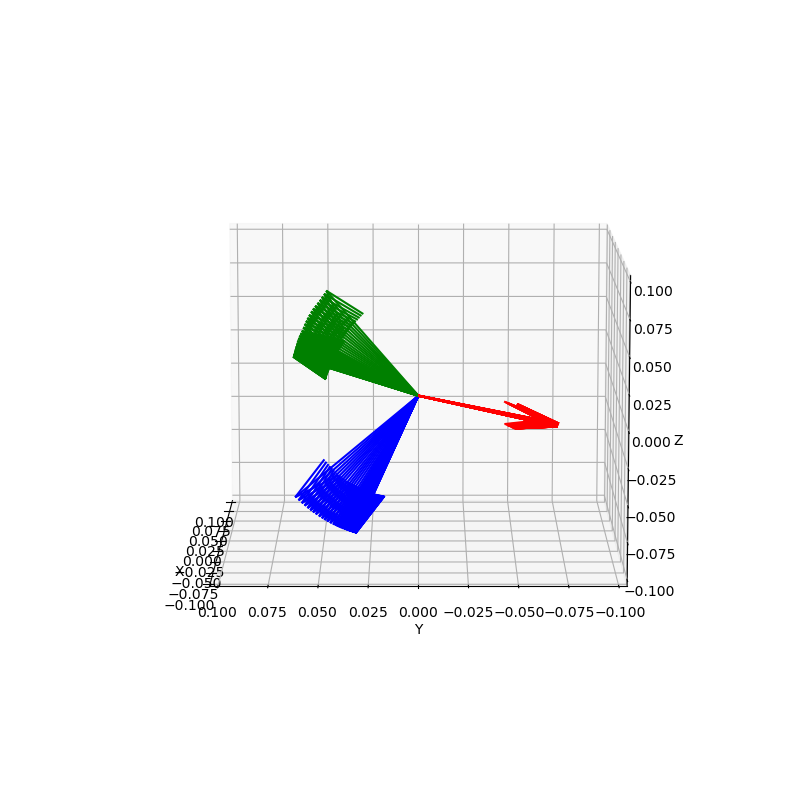

-3 0.0 0.5674742889567052
-3 0.015873015873015872 0.5562896766004584
-3 0.031746031746031744 0.5469028843219397
-3 0.047619047619047616 0.5383613713000929
-3 0.06349206349206349 0.530321905980497
-3 0.07936507936507936 0.5235272438408255
-3 0.09523809523809523 0.5173953332502897
-3 0.1111111111111111 0.5115142084543992
-3 0.12698412698412698 0.5061364483412719
-3 0.14285714285714285 0.5006249558699585
-3 0.15873015873015872 0.49548167447823477
-3 0.1746031746031746 0.4912395154456657
-3 0.19047619047619047 0.48703666600331846
-3 0.20634920634920634 0.4827499208005491
-3 0.2222222222222222 0.47815867119573413
-3 0.23809523809523808 0.47352065524898673
-3 0.25396825396825395 0.4689082945399051
-3 0.2698412698412698 0.46450966082823797
-3 0.2857142857142857 0.459955434833515
-3 0.30158730158730157 0.4550894988858206
-3 0.31746031746031744 0.4502370040193312
-3 0.3333333333333333 0.44558498872112795
-3 0.3492063492063492 0.4409159749444362
-3 0.36507936507936506 0.4364147787057648
-3 0.380

<IPython.core.display.Javascript object>


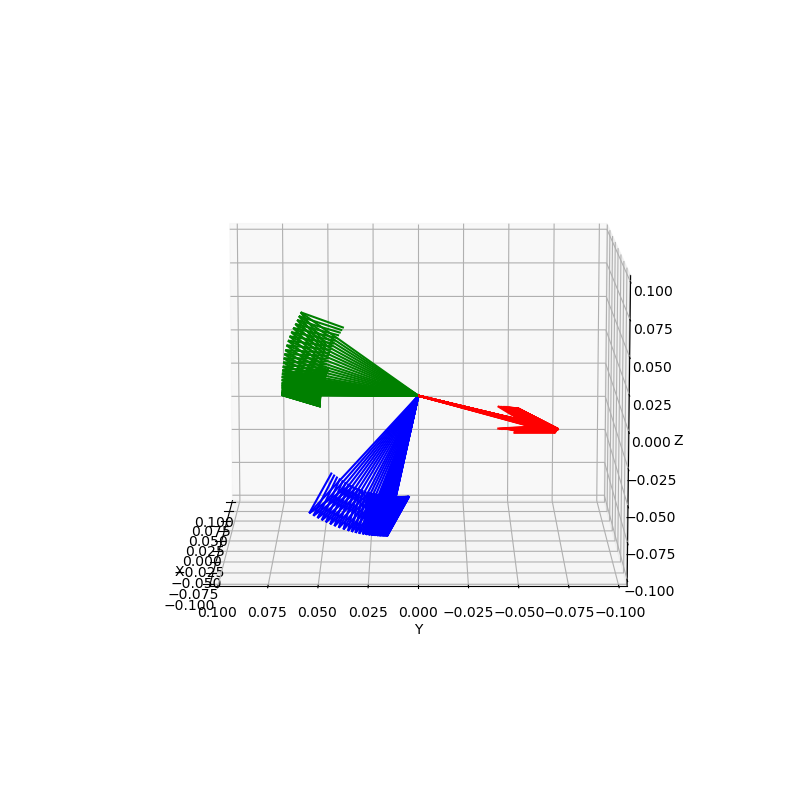

-1.5 0.0 0.31030209567102085
-1.5 0.015873015873015872 0.2974081140659286
-1.5 0.031746031746031744 0.28645489322719464
-1.5 0.047619047619047616 0.27769597285650105
-1.5 0.06349206349206349 0.27042269305073197
-1.5 0.07936507936507936 0.26339923996388326
-1.5 0.09523809523809523 0.2568906034027552
-1.5 0.1111111111111111 0.2512699492722574
-1.5 0.12698412698412698 0.24556097774457672
-1.5 0.14285714285714285 0.23990566333667968
-1.5 0.15873015873015872 0.23440010454943142
-1.5 0.1746031746031746 0.22943286218393869
-1.5 0.19047619047619047 0.225216823851499
-1.5 0.20634920634920634 0.2212398044106308
-1.5 0.2222222222222222 0.21704999493847874
-1.5 0.23809523809523808 0.212864834538306
-1.5 0.25396825396825395 0.20871256370646282
-1.5 0.2698412698412698 0.20441967357773771
-1.5 0.2857142857142857 0.20035468101080586
-1.5 0.30158730158730157 0.19681451443391465
-1.5 0.31746031746031744 0.19325433734243752
-1.5 0.3333333333333333 0.18942784836368354
-1.5 0.3492063492063492 0.18546981209

<IPython.core.display.Javascript object>


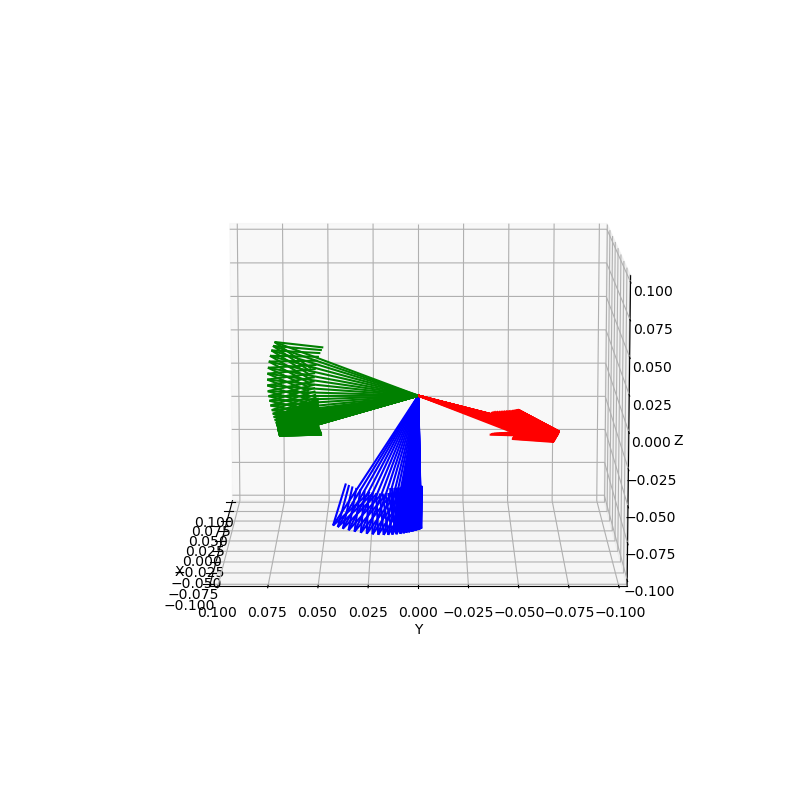

0 0.0 0.02760186008544161
0 0.015873015873015872 0.015899101632351288
0 0.031746031746031744 0.0046176085139824075
0 0.047619047619047616 -0.00513134861126488
0 0.06349206349206349 -0.013227627384158919
0 0.07936507936507936 -0.020867433110963098
0 0.09523809523809523 -0.027806975189257368
0 0.1111111111111111 -0.03442885077186136
0 0.12698412698412698 -0.04108518584952636
0 0.14285714285714285 -0.04732119162124406
0 0.15873015873015872 -0.05336463351175364
0 0.1746031746031746 -0.059212460640700286
0 0.19047619047619047 -0.06371015149759841
0 0.20634920634920634 -0.06792808775516143
0 0.2222222222222222 -0.07194812187982505
0 0.23809523809523808 -0.07593279558931192
0 0.25396825396825395 -0.0797530394836158
0 0.2698412698412698 -0.08326708537331982
0 0.2857142857142857 -0.08669760842872233
0 0.30158730158730157 -0.08984603635491287
0 0.31746031746031744 -0.09304520976414041
0 0.3333333333333333 -0.0962534669248673
0 0.3492063492063492 -0.09947531783066857
0 0.36507936507936506 -0.1024

In [15]:
# Confirm our tip orientation/poses look correct in our "Standard Robot Base" coordinate frame
# https://matplotlib.org/stable/gallery/mplot3d/quiver3d.html
for i in [-3,-1.5,0]:
    ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
    curminblue = 10
    for ts in np.linspace(0,1,64):
        latent = torch.tensor((0,i,i),dtype=torch.float32).reshape(1,3)
        t = torch.tensor((ts),dtype=torch.float32).reshape(1,1)
        scaled_pose, _ = loaded_vae.decode(latent,t)
        pose = unscale_poses(scaled_pose.detach().cpu().numpy())
        quat = pose[0,3:]
        base_quat = (0,0,1,0)
        #quat = t3d.quaternions.qmult(base_quat,quat)
        #quat=base_quat
        #print(t3d.euler.quat2euler(quat,axes='sxyz'))
        rotMat = t3d.quaternions.quat2mat(quat)
        ax.quiver(0,0,0, *(rotMat @ [1,0,0]), length=0.1, normalize=False, color="red")
        ax.quiver(0,0,0, *(rotMat @ [0,1,0]), length=0.1, normalize=False, color="green")
        ax.quiver(0,0,0, *(rotMat @ [0,0,1]), length=0.1, normalize=False, color="blue")
        if ((rotMat @ [0,1,0])[2]) < curminblue:
            curminblue = (rotMat @ [0,1,0])[2]
            print(i,ts,curminblue)
    ax.view_init(elev=10, azim=180)
    scale = 0.1
    ax.set_xlim(-scale,scale)
    ax.set_ylim(-scale,scale)
    ax.set_zlim(-scale,scale)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

<IPython.core.display.Javascript object>


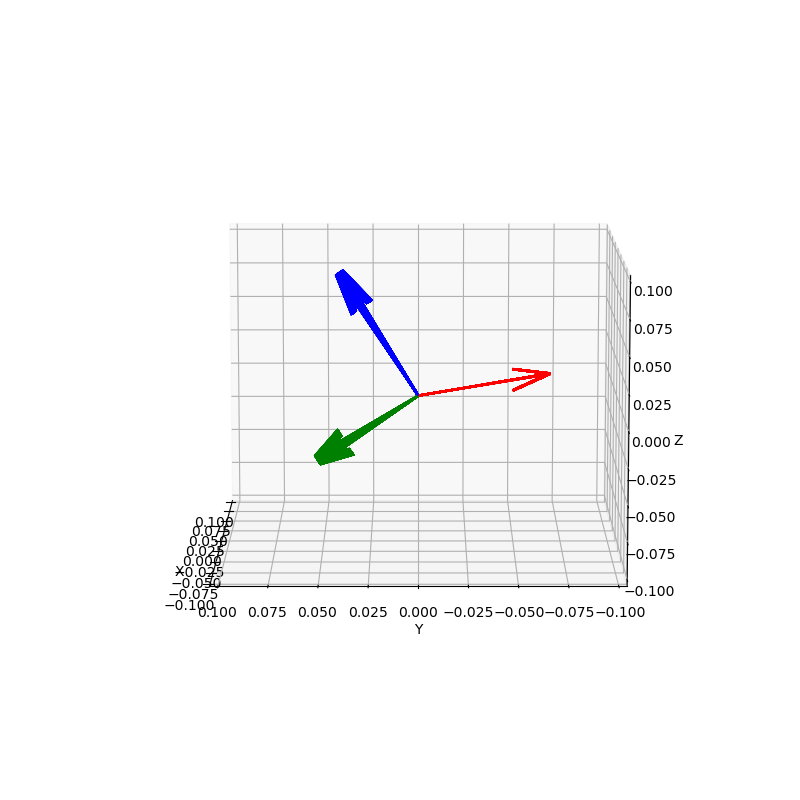

The fork prongs are about 60 degrees off vertical for latent -3.408080808080808,-3.1454545454545455
The fork prongs are about 60 degrees off vertical for latent -3.4030303030303033,-3.1494949494949496
The fork prongs are about 60 degrees off vertical for latent -3.4030303030303033,-3.1454545454545455
The fork prongs are about 60 degrees off vertical for latent -3.4030303030303033,-3.1414141414141414
The fork prongs are about 60 degrees off vertical for latent -3.4030303030303033,-3.1373737373737374
The fork prongs are about 60 degrees off vertical for latent -3.397979797979798,-3.1535353535353536
The fork prongs are about 60 degrees off vertical for latent -3.397979797979798,-3.1494949494949496
The fork prongs are about 60 degrees off vertical for latent -3.397979797979798,-3.1454545454545455
The fork prongs are about 60 degrees off vertical for latent -3.397979797979798,-3.1414141414141414
The fork prongs are about 60 degrees off vertical for latent -3.397979797979798,-3.1373737373737

Text(0.5, 0, 'Z')

In [23]:
t = torch.tensor((0.5),dtype=torch.float32).reshape(1,1)
# Confirm our tip orientation/poses look correct in our "Standard Robot Base" coordinate frame
# https://matplotlib.org/stable/gallery/mplot3d/quiver3d.html
ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
eul_array = []
target_degrees = 60
accuracy_degrees = 0.1
for i in np.linspace(-3.6,-3.1,100):
  for j in np.linspace(-3.4,-3.0,100):
    latent = torch.tensor((0,i,j),dtype=torch.float32).reshape(1,3)
    t = torch.tensor((0),dtype=torch.float32).reshape(1,1)
    scaled_pose, _ = loaded_vae.decode(latent,t)
    pose = unscale_poses(scaled_pose.detach().cpu().numpy())
    quat = pose[0,3:]
    base_quat = (0,0,1,0)
    quat = t3d.quaternions.qmult(base_quat,quat)
    #quat=base_quat
    eul = t3d.euler.quat2euler(quat,axes='sxyz')
    if not np.abs(eul[1] * 180/ np.pi) < accuracy_degrees:
        continue
    eul_array.append(eul)
    #print(eul)
    rotMat = t3d.quaternions.quat2mat(quat)
    ax.quiver(0,0,0, *(rotMat @ [1,0,0]), length=0.1, normalize=False, color="red")
    ax.quiver(0,0,0, *(rotMat @ [0,1,0]), length=0.1, normalize=False, color="green")
    ax.quiver(0,0,0, *(rotMat @ [0,0,1]), length=0.1, normalize=False, color="blue")
    angle_definition = eul[0]-0.4 # fork prongs off of axis
    angle_degrees = angle_definition/np.pi * 180
    if not np.abs(angle_degrees + target_degrees) < accuracy_degrees:
        continue
    print(f"The fork prongs are about {-angle_degrees:0.0f} degrees off vertical for latent {i},{j}")
ax.view_init(elev=10, azim=180)
scale = 0.1
ax.set_xlim(-scale,scale)
ax.set_ylim(-scale,scale)
ax.set_zlim(-scale,scale)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

<IPython.core.display.Javascript object>


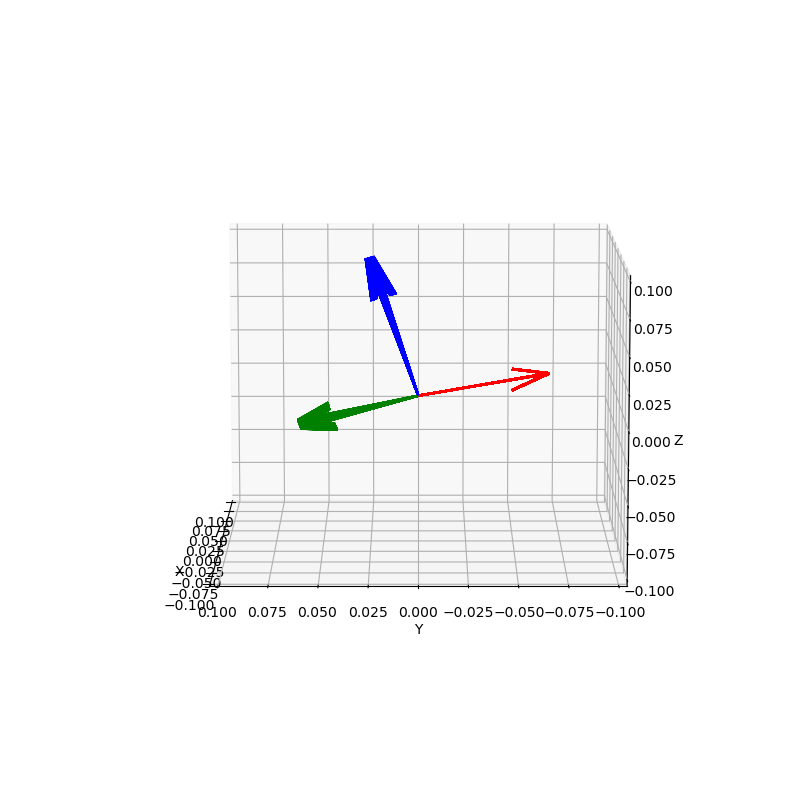

The fork prongs are about 45 degrees off vertical for latent -2.3181818181818183,-1.5545454545454545
The fork prongs are about 45 degrees off vertical for latent -2.3181818181818183,-1.5505050505050506
The fork prongs are about 45 degrees off vertical for latent -2.3181818181818183,-1.5464646464646465
The fork prongs are about 45 degrees off vertical for latent -2.313131313131313,-1.5585858585858585
The fork prongs are about 45 degrees off vertical for latent -2.313131313131313,-1.5545454545454545
The fork prongs are about 45 degrees off vertical for latent -2.313131313131313,-1.5505050505050506
The fork prongs are about 45 degrees off vertical for latent -2.313131313131313,-1.5464646464646465
The fork prongs are about 45 degrees off vertical for latent -2.313131313131313,-1.5424242424242425
The fork prongs are about 45 degrees off vertical for latent -2.313131313131313,-1.5383838383838384
The fork prongs are about 45 degrees off vertical for latent -2.308080808080808,-1.55858585858585

Text(0.5, 0, 'Z')

In [26]:
t = torch.tensor((0.5),dtype=torch.float32).reshape(1,1)
# Confirm our tip orientation/poses look correct in our "Standard Robot Base" coordinate frame
# https://matplotlib.org/stable/gallery/mplot3d/quiver3d.html
ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
eul_array = []
accuracy_degrees = 0.1
target_degrees = 45
for i in np.linspace(-2.5,-2,100):
  for j in np.linspace(-1.7,-1.3,100):
    latent = torch.tensor((0,i,j),dtype=torch.float32).reshape(1,3)
    t = torch.tensor((0),dtype=torch.float32).reshape(1,1)
    scaled_pose, _ = loaded_vae.decode(latent,t)
    pose = unscale_poses(scaled_pose.detach().cpu().numpy())
    quat = pose[0,3:]
    base_quat = (0,0,1,0)
    quat = t3d.quaternions.qmult(base_quat,quat)
    #quat=base_quat
    eul = t3d.euler.quat2euler(quat,axes='sxyz')
    if not np.abs(eul[1] * 180/ np.pi) < accuracy_degrees:
        continue
    eul_array.append(eul)
    #print(eul)
    rotMat = t3d.quaternions.quat2mat(quat)
    ax.quiver(0,0,0, *(rotMat @ [1,0,0]), length=0.1, normalize=False, color="red")
    ax.quiver(0,0,0, *(rotMat @ [0,1,0]), length=0.1, normalize=False, color="green")
    ax.quiver(0,0,0, *(rotMat @ [0,0,1]), length=0.1, normalize=False, color="blue")
    angle_definition = eul[0]-0.4 # fork prongs off of axis
    angle_degrees = angle_definition/np.pi * 180
    if not np.abs(angle_degrees + target_degrees) < accuracy_degrees:
        continue
    print(f"The fork prongs are about {-angle_degrees:0.0f} degrees off vertical for latent {i},{j}")
ax.view_init(elev=10, azim=180)
scale = 0.1
ax.set_xlim(-scale,scale)
ax.set_ylim(-scale,scale)
ax.set_zlim(-scale,scale)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

<IPython.core.display.Javascript object>


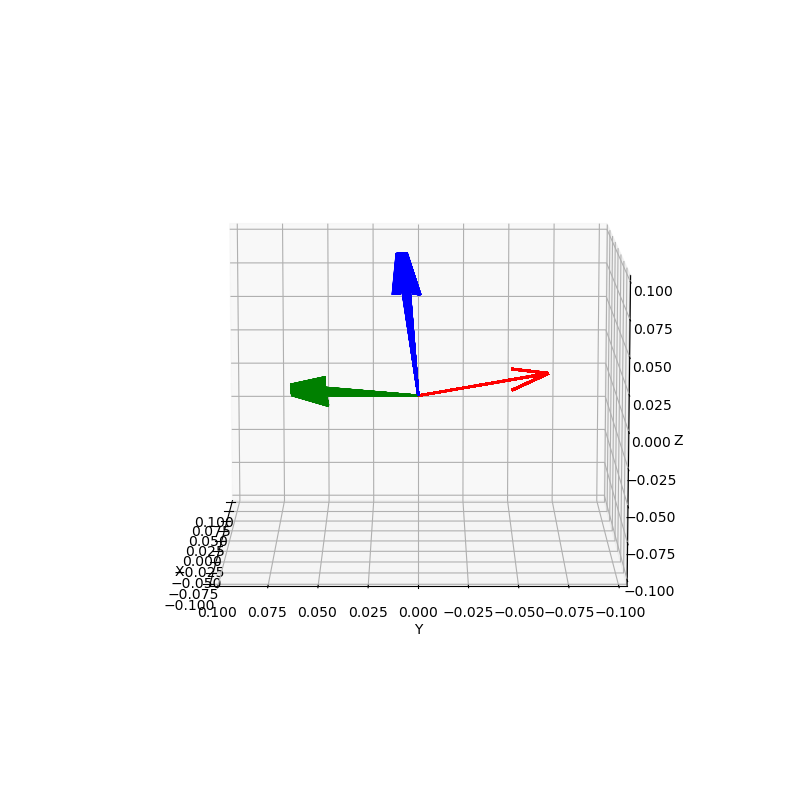

The fork prongs are about 30 degrees off vertical for latent -1.2626262626262625,0.0696969696969697
The fork prongs are about 30 degrees off vertical for latent -1.2585858585858585,0.06363636363636366
The fork prongs are about 30 degrees off vertical for latent -1.2585858585858585,0.0696969696969697
The fork prongs are about 30 degrees off vertical for latent -1.2585858585858585,0.07575757575757575
The fork prongs are about 30 degrees off vertical for latent -1.2545454545454544,0.06363636363636366
The fork prongs are about 30 degrees off vertical for latent -1.2545454545454544,0.0696969696969697
The fork prongs are about 30 degrees off vertical for latent -1.2545454545454544,0.07575757575757575
The fork prongs are about 30 degrees off vertical for latent -1.2545454545454544,0.08181818181818185
The fork prongs are about 30 degrees off vertical for latent -1.2505050505050503,0.05757575757575761
The fork prongs are about 30 degrees off vertical for latent -1.2505050505050503,0.06363636363

Text(0.5, 0, 'Z')

In [41]:
t = torch.tensor((0.5),dtype=torch.float32).reshape(1,1)
# Confirm our tip orientation/poses look correct in our "Standard Robot Base" coordinate frame
# https://matplotlib.org/stable/gallery/mplot3d/quiver3d.html
ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
eul_array = []
accuracy_degrees = 0.1
target_degrees = 30
for i in np.linspace(-1.4,-1.0,100):
  for j in np.linspace(-0.3,0.3,100):
    latent = torch.tensor((0,i,j),dtype=torch.float32).reshape(1,3)
    t = torch.tensor((0),dtype=torch.float32).reshape(1,1)
    scaled_pose, _ = loaded_vae.decode(latent,t)
    pose = unscale_poses(scaled_pose.detach().cpu().numpy())
    quat = pose[0,3:]
    base_quat = (0,0,1,0)
    quat = t3d.quaternions.qmult(base_quat,quat)
    #quat=base_quat
    eul = t3d.euler.quat2euler(quat,axes='sxyz')
    if not np.abs(eul[1] * 180/ np.pi) < accuracy_degrees:
        continue
    eul_array.append(eul)
    #print(eul)
    rotMat = t3d.quaternions.quat2mat(quat)
    ax.quiver(0,0,0, *(rotMat @ [1,0,0]), length=0.1, normalize=False, color="red")
    ax.quiver(0,0,0, *(rotMat @ [0,1,0]), length=0.1, normalize=False, color="green")
    ax.quiver(0,0,0, *(rotMat @ [0,0,1]), length=0.1, normalize=False, color="blue")
    angle_definition = eul[0]-0.4 # fork prongs off of axis
    angle_degrees = angle_definition/np.pi * 180
    #print(angle_degrees)
    if not np.abs(angle_degrees + target_degrees) < accuracy_degrees:
        continue
    print(f"The fork prongs are about {-angle_degrees:0.0f} degrees off vertical for latent {i},{j}")
ax.view_init(elev=10, azim=180)
scale = 0.1
ax.set_xlim(-scale,scale)
ax.set_ylim(-scale,scale)
ax.set_zlim(-scale,scale)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

In [ ]:
Final_Choices = [[0,-3.4,-3.1],[0,-2.3,-1.5],[0,-1.2,0.1]]

<IPython.core.display.Javascript object>


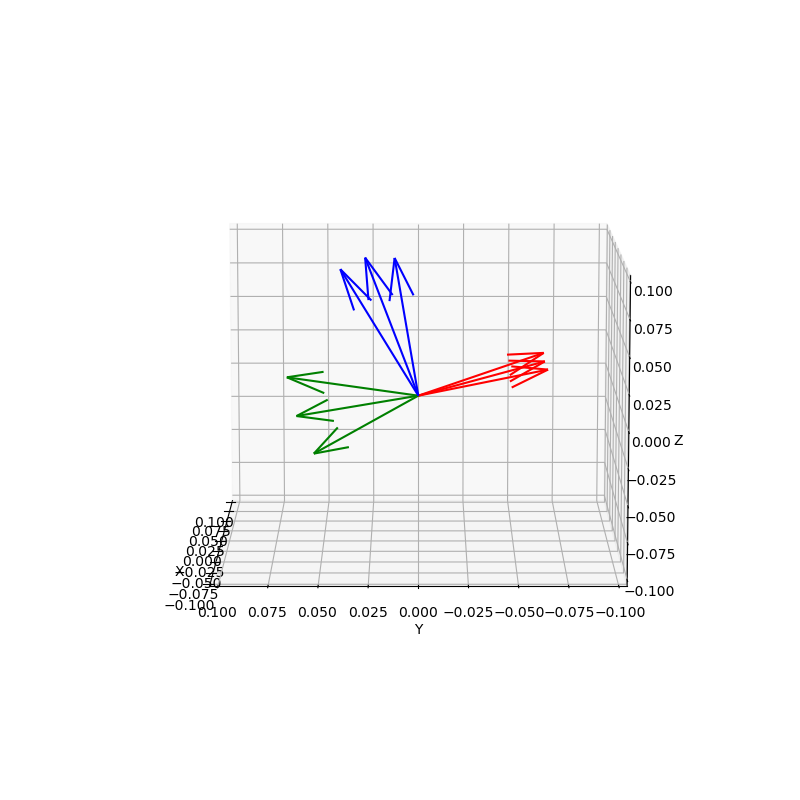

(-0.6036883127690266, -0.02709932727147664, -0.7879687393904494)
The fork prongs are about 58 degrees off vertical for latent -3
(-0.3166853107908511, -0.08469688771923096, -0.766659623713088)
The fork prongs are about 41 degrees off vertical for latent -1.5
(-0.027915781107042372, -0.14924821342357875, -0.7650563784415292)
The fork prongs are about 25 degrees off vertical for latent 0


Text(0.5, 0, 'Z')

In [17]:
t = torch.tensor((0.5),dtype=torch.float32).reshape(1,1)
# Confirm our tip orientation/poses look correct in our "Standard Robot Base" coordinate frame
# https://matplotlib.org/stable/gallery/mplot3d/quiver3d.html
ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
eul_array = []
for i in [-3,-1.5,0]:
    latent = torch.tensor((0,i,i),dtype=torch.float32).reshape(1,3)
    t = torch.tensor((0),dtype=torch.float32).reshape(1,1)
    scaled_pose, _ = loaded_vae.decode(latent,t)
    pose = unscale_poses(scaled_pose.detach().cpu().numpy())
    quat = pose[0,3:]
    base_quat = (0,0,1,0)
    quat = t3d.quaternions.qmult(base_quat,quat)
    #quat=base_quat
    eul = t3d.euler.quat2euler(quat,axes='sxyz')
    eul_array.append(eul)
    print(eul)
    rotMat = t3d.quaternions.quat2mat(quat)
    ax.quiver(0,0,0, *(rotMat @ [1,0,0]), length=0.1, normalize=False, color="red")
    ax.quiver(0,0,0, *(rotMat @ [0,1,0]), length=0.1, normalize=False, color="green")
    ax.quiver(0,0,0, *(rotMat @ [0,0,1]), length=0.1, normalize=False, color="blue")
    angle_definition = eul[0]-0.4 # fork prongs off of axis
    angle_degrees = angle_definition/np.pi * 180
    print(f"The fork prongs are about {-angle_degrees:0.0f} degrees off vertical for latent {i}")
ax.view_init(elev=10, azim=180)
scale = 0.1
ax.set_xlim(-scale,scale)
ax.set_ylim(-scale,scale)
ax.set_zlim(-scale,scale)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

<IPython.core.display.Javascript object>


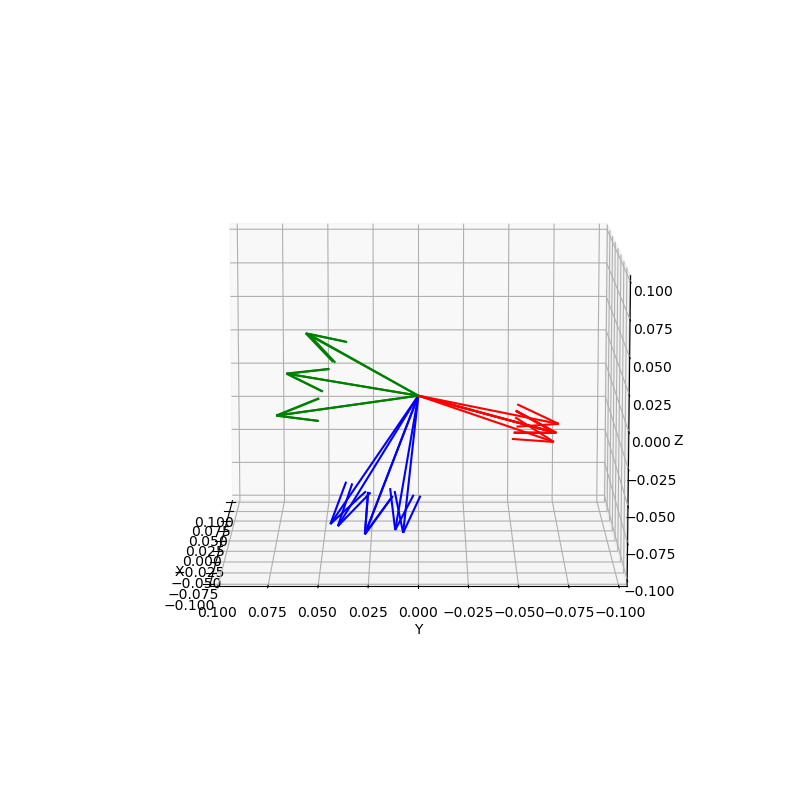

(2.537904340820767, 0.027099327271476636, -2.3536239141993436)
(2.824907342798942, 0.08469688771923098, -2.374933029876705)
(3.113676872482751, 0.14924821342357877, -2.3765362751482644)


Text(0.5, 0, 'Z')

In [18]:
eul_array = np.array(eul_array)
eul_means = np.mean(eul_array,axis=0)
eul_approx = [[e[0],eul_means[1],eul_means[2]] for e in eul_array]

# Confirm our tip orientation/poses look correct in our "Standard Robot Base" coordinate frame
# https://matplotlib.org/stable/gallery/mplot3d/quiver3d.html
ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
for i in [-3,-1.5,0]:
    latent = torch.tensor((0,i,i),dtype=torch.float32).reshape(1,3)
    scaled_pose, _ = loaded_vae.decode(latent,t)
    pose = unscale_poses(scaled_pose.detach().cpu().numpy())
    quat = pose[0,3:]
    base_quat = (0,0,1,0)
    #quat = t3d.quaternions.qmult(base_quat,quat)
    #quat=base_quat
    print(t3d.euler.quat2euler(quat,axes='sxyz'))
    rotMat = t3d.quaternions.quat2mat(quat)
    ax.quiver(0,0,0, *(rotMat @ [1,0,0]), length=0.1, normalize=False, color="red")
    ax.quiver(0,0,0, *(rotMat @ [0,1,0]), length=0.1, normalize=False, color="green")
    ax.quiver(0,0,0, *(rotMat @ [0,0,1]), length=0.1, normalize=False, color="blue")
    
for eul in eul_approx:
    quat = t3d.euler.euler2quat(eul[0],eul[1],eul[2],axes='sxyz')
    base_quat = (0,0,1,0)
    quat = t3d.quaternions.qmult(base_quat,quat)
    rotMat = t3d.quaternions.quat2mat(quat)
    ax.quiver(0,0,0, *(rotMat @ [1,0,0]), length=0.1, normalize=False, color="red")
    ax.quiver(0,0,0, *(rotMat @ [0,1,0]), length=0.1, normalize=False, color="green")
    ax.quiver(0,0,0, *(rotMat @ [0,0,1]), length=0.1, normalize=False, color="blue")
ax.view_init(elev=10, azim=180)
scale = 0.1
ax.set_xlim(-scale,scale)
ax.set_ylim(-scale,scale)
ax.set_zlim(-scale,scale)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

<IPython.core.display.Javascript object>


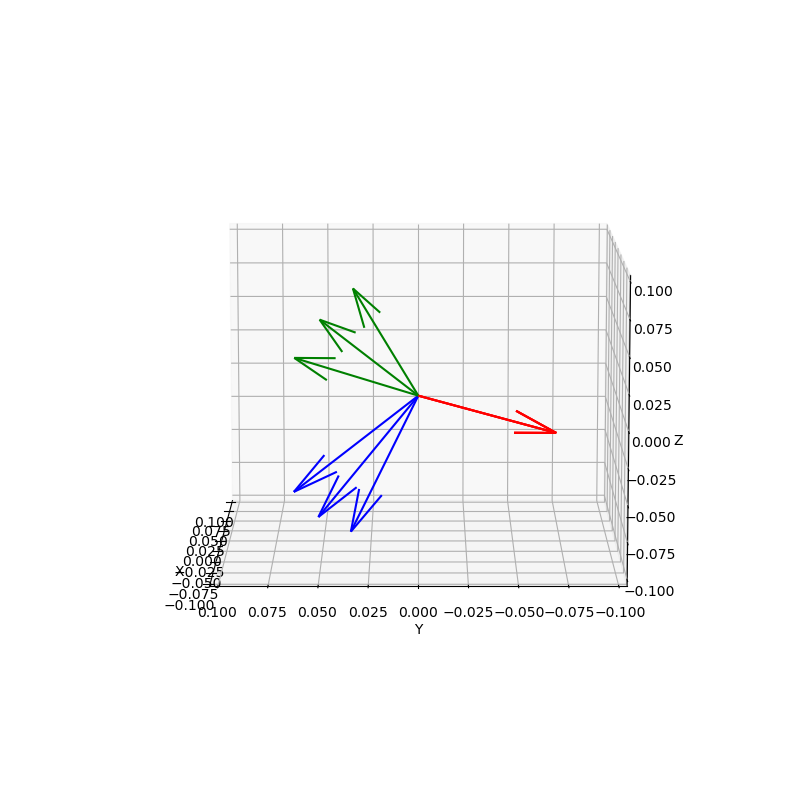

The fork prongs are about 58 degrees off vertical
The fork prongs are about 41 degrees off vertical
The fork prongs are about 25 degrees off vertical


In [19]:
# now, finally, compute the offsets in degrees
# remembering that the fork tips are (negative) 0.4 radians off of the fork centerline

ax = plt.figure(figsize=(8,8)).add_subplot(projection='3d')
for eul in eul_approx:
    angle_definition = eul[0]-0.4
    angle_degrees = angle_definition/np.pi * 180
    print(f"The fork prongs are about {-angle_degrees:0.0f} degrees off vertical")
    quat = t3d.euler.euler2quat(angle_definition,eul[1],eul[2],axes='sxyz')
    base_quat = (0,0,1,0)
    quat = t3d.quaternions.qmult(base_quat,quat)
    rotMat = t3d.quaternions.quat2mat(quat)
    ax.quiver(0,0,0, *(rotMat @ [1,0,0]), length=0.1, normalize=False, color="red")
    ax.quiver(0,0,0, *(rotMat @ [0,1,0]), length=0.1, normalize=False, color="green")
    ax.quiver(0,0,0, *(rotMat @ [0,0,1]), length=0.1, normalize=False, color="blue")
ax.view_init(elev=10, azim=180)
scale = 0.1
ax.set_xlim(-scale,scale)
ax.set_ylim(-scale,scale)
ax.set_zlim(-scale,scale)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z");